# Requirements

In [ ]:
!pip install owlready2
!pip install numpy
!pip install scikit-learn==1.5.2
!pip install tensorflow==2.9.0
!pip install ampligraph

# Knowledge graph creation

In [ ]:
def clear_namespace(subj):
  return subj.split('#')[-1] if '#' in str(subj) else str(subj).split('/')[-1]

In [ ]:
from rdflib import *

# Загружаем онтологию
g = Graph()
g.parse("updated_ontology.owl")

/usr/local/lib/python3.10/dist-packages/rdflib/term.py:1760: UserWarning: Parsing weird boolean, 'nan' does not map to True or False
  warnings.warn(


<Graph identifier=N032723ae7a4d4563bf5cd669a704524a (<class 'rdflib.graph.Graph'>)>

In [ ]:
triples = []
# Получаем триплеты
for subject, predicate, obj in g:
    subject_clean = clear_namespace(subject)

    if isinstance(obj, Literal):
        if obj.datatype == XSD.float:
            obj_value = float(obj)
        else:
            obj_value = str(obj)
    elif isinstance(obj, URIRef):
        obj_value = obj.fragment
    else:
        print(obj_value)
        obj_value = None
    triples.append((subject_clean, predicate.fragment, obj_value))


In [ ]:
# Проверяем формат триплетов
for triple in triples[:5]:
  print(triple)

('Electronics_&_Comfort', 'type', 'Class')
('Car_589', 'hasSeatingCapacity', 5.0)
('Car_4', 'hasDimension', 'Small')
('Engine_108', 'hasPower', 299.0)
('Engine_11', 'hasTorque', 99.04)


In [ ]:
import pandas as pd
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df[(triples_df.subject=="Car_1")]

,subject,predicate,object
4717,Car_1,hasFuelType,Petrol
6965,Car_1,hasVariant,Xe
8825,Car_1,hasExShowroomPrice,288465.0
8972,Car_1,hasAppearance,Appearance_1
10743,Car_1,hasWheelbase,2230.0
12570,Car_1,hasDimension,Small
15587,Car_1,type,Car
16941,Car_1,hasMake,Tata
19078,Car_1,hasModel,Nano Genx
19258,Car_1,hasEngine,Engine_0


# Training knowledge graph embeddings

In [ ]:
from ampligraph.evaluation import train_test_split_no_unseen
import numpy as np

X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=0.2)
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (23340, 3)
Test set size:  (5835, 3)


In [ ]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer
import ampligraph
import tensorflow as tf

model = ScoringBasedEmbeddingModel(k=100,
                                   eta=20,
                                   scoring_type='ComplEx',
                                   seed=0)

# Optimizer, loss and regularizer definition
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

# Compilation of the model
model.compile(optimizer=optimizer, loss=loss, entity_relation_regularizer=regularizer)

In [ ]:
model.fit(X_train,
          batch_size=int(X_train.shape[0] / 50),
          epochs=300, # Number of training epochs
          verbose=True # Displays a progress bar.
          )

Epoch 1/300
52/52 [==============================] - 5s 88ms/step - loss: 1393.3191
Epoch 2/300
52/52 [==============================] - 3s 58ms/step - loss: 1393.2811
Epoch 3/300
52/52 [==============================] - 3s 59ms/step - loss: 1393.2428
Epoch 4/300
52/52 [==============================] - 4s 80ms/step - loss: 1393.2003
Epoch 5/300
52/52 [==============================] - 3s 61ms/step - loss: 1393.1517
Epoch 6/300
52/52 [==============================] - 3s 59ms/step - loss: 1393.0923
Epoch 7/300
52/52 [==============================] - 3s 59ms/step - loss: 1393.0170
Epoch 8/300
52/52 [==============================] - 4s 78ms/step - loss: 1392.9176
Epoch 9/300
52/52 [==============================] - 3s 61ms/step - loss: 1392.7816
Epoch 10/300
52/52 [==============================] - 3s 58ms/step - loss: 1392.5935
Epoch 11/300
52/52 [==============================] - 3s 67ms/step - loss: 1392.3297
Epoch 12/300
52/52 [==============================] - 4s 73ms/step - loss:

# Evaluating knowledge embeddings

In [ ]:
ranks = model.evaluate(X_valid,
                      use_filter={'train': X_train,
                                  'test': X_valid},
                      corrupt_side='s,o',
                      verbose=True)

585/585 [==============================] - 42s 72ms/step


In [ ]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.39
MR: 188.48
Hits@10: 0.50
Hits@3: 0.43
Hits@1: 0.32


# Clustering and embedding visualization

In [ ]:
!git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
!cd incf.countryutils && pip install .

fatal: destination path 'incf.countryutils' already exists and is not an empty directory.
Processing /content/incf.countryutils
  Preparing metadata (setup.py) ... done
  Created wheel for incf.countryutils: filename=incf.countryutils-1.2-py3-none-any.whl size=21366 sha256=ea9710eacfde2ce91367efe70d45afd2e642cd66f1a31326e3cdacad5108ba31
  Stored in directory: /tmp/pip-ephem-wheel-cache-wkxqgkhb/wheels/c9/1a/60/d7400cda03816dbfc1647ccbb66be83b3e42077058131932d1
Successfully built incf.countryutils
  Attempting uninstall: incf.countryutils
    Found existing installation: incf.countryutils 1.2
    Uninstalling incf.countryutils-1.2:
      Successfully uninstalled incf.countryutils-1.2


In [ ]:
!pip install adjustText

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from incf.countryutils import transformations
%matplotlib inline

In [ ]:
df = pd.read_csv(f"new_cars.csv")

In [ ]:
df.Company.unique()

array(['Tata', 'Datsun', 'Renault', 'Maruti Suzuki', 'Hyundai', 'Premier',
       'Toyota', 'Nissan', 'Volkswagen', 'Ford', 'Mahindra', 'Fiat',
       'Honda', 'Jeep', 'Isuzu', 'Skoda', 'Audi', 'Mercedes-Benz', 'Dc',
       'Mini', 'Volvo', 'Jaguar', 'Bmw', 'Land Rover', 'Porsche', 'Lexus',
       'Maserati', 'Lamborghini', 'Bentley', 'Ferrari', 'Aston Martin',
       'Rolls-Royce', 'Bugatti', 'Bajaj', 'Icml', 'Force', 'Mg', 'Kia',
       'Mitsubishi', 'Maruti Suzuki R'], dtype=object)

In [ ]:
companies = df.Company.unique()

company_embeddings = dict(zip(companies, model.get_embeddings(companies)))
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in company_embeddings.values()]))

In [ ]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

clustering_algorithm = KMeans(n_clusters=6, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(companies, model, clustering_algorithm, mode='e')

In [ ]:
def get_country_by_company(company_name):
    # Dictionary mapping car manufacturers to their countries
    manufacturers_country = {
        'Tata': 'India',
        'Datsun': 'Japan',
        'Renault': 'France',
        'Maruti Suzuki': 'India',
        'Hyundai': 'South Korea',
        'Premier': 'India',
        'Toyota': 'Japan',
        'Nissan': 'Japan',
        'Volkswagen': 'Germany',
        'Ford': 'USA',
        'Mahindra': 'India',
        'Fiat': 'Italy',
        'Honda': 'Japan',
        'Jeep': 'USA',
        'Isuzu': 'Japan',
        'Skoda': 'Czech Republic',
        'Audi': 'Germany',
        'Mercedes-Benz': 'Germany',
        'Dc': 'India',
        'Mini': 'UK',
        'Volvo': 'Sweden',
        'Jaguar': 'UK',
        'Bmw': 'Germany',
        'Land Rover': 'UK',
        'Porsche': 'Germany',
        'Lexus': 'Japan',
        'Maserati': 'Italy',
        'Lamborghini': 'Italy',
        'Bentley': 'UK',
        'Ferrari': 'Italy',
        'Aston Martin': 'UK',
        'Rolls-Royce': 'UK',
        'Bugatti': 'France',
        'Bajaj': 'India',
        'Icml': 'India',
        'Force': 'India',
        'Mg': 'UK',  # MG Motor
        'Kia': 'South Korea',
        'Mitsubishi': 'Japan',
        'Maruti Suzuki R': 'India'
    }

    # Return the country for the given company name, or "Unknown" if not found
    return manufacturers_country.get(company_name, "Unknown Manufacturer")

# Example usage
company_names = [
    "Tata", "Datsun", "Renault", "Maruti Suzuki", "Hyundai", "Premier",
    "Toyota", "Nissan", "Volkswagen", "Ford", "Mahindra", "Fiat",
    "Honda", "Jeep", "Isuzu", "Skoda", "Audi", "Mercedes-Benz", "Dc",
    "Mini", "Volvo", "Jaguar", "Bmw", "Land Rover", "Porsche", "Lexus",
    "Maserati", "Lamborghini", "Bentley", "Ferrari", "Aston Martin",
    "Rolls-Royce", "Bugatti", "Bajaj", "Icml", "Force", "Mg", "Kia",
    "Mitsubishi", "Maruti Suzuki R"
]

for company in company_names:
    country = get_country_by_company(company)
    print(f"The manufacturer {company} is from {country}.")

The manufacturer Tata is from India.
The manufacturer Datsun is from Japan.
The manufacturer Renault is from France.
The manufacturer Maruti Suzuki is from India.
The manufacturer Hyundai is from South Korea.
The manufacturer Premier is from India.
The manufacturer Toyota is from Japan.
The manufacturer Nissan is from Japan.
The manufacturer Volkswagen is from Germany.
The manufacturer Ford is from USA.
The manufacturer Mahindra is from India.
The manufacturer Fiat is from Italy.
The manufacturer Honda is from Japan.
The manufacturer Jeep is from USA.
The manufacturer Isuzu is from Japan.
The manufacturer Skoda is from Czech Republic.
The manufacturer Audi is from Germany.
The manufacturer Mercedes-Benz is from Germany.
The manufacturer Dc is from India.
The manufacturer Mini is from UK.
The manufacturer Volvo is from Sweden.
The manufacturer Jaguar is from UK.
The manufacturer Bmw is from Germany.
The manufacturer Land Rover is from UK.
The manufacturer Porsche is from Germany.
The ma

In [ ]:
plot_df = pd.DataFrame({"models": companies,
                        "embedding1": embeddings_2d[:, 0],
                        "embedding2": embeddings_2d[:, 1],
                        "country": pd.Series(companies).apply(get_country_by_company),
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

In [ ]:
top_cmp = df.Company.unique()

def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df, x="embedding1", y="embedding2", hue=hue)
    texts = []
    for i, point in plot_df.iterrows():
        if point["models"] in top_cmp or np.random.random() < 0.1:
            texts.append(plt.text(point['embedding1'] + 0.02, point['embedding2'] + 0.01, str(point["models"])))
    adjust_text(texts)

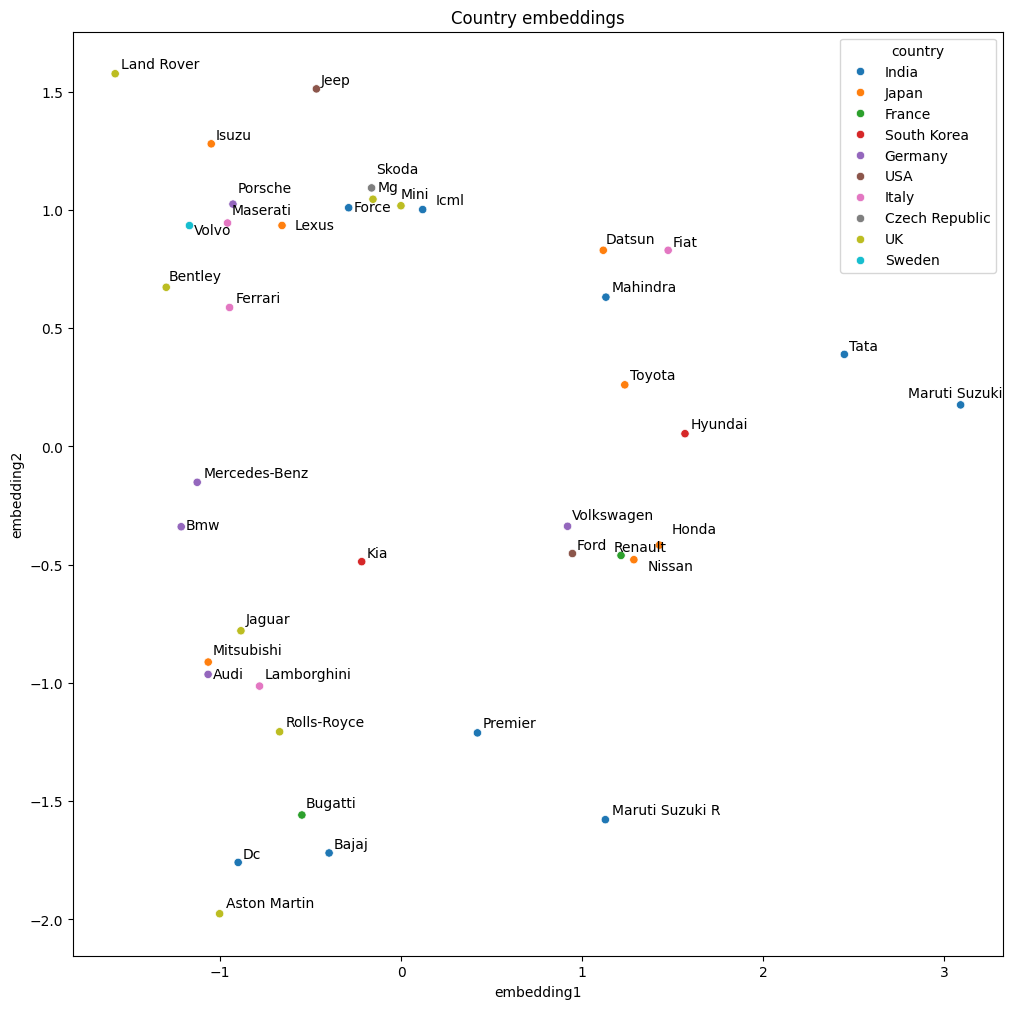

In [ ]:
plot_clusters('country')

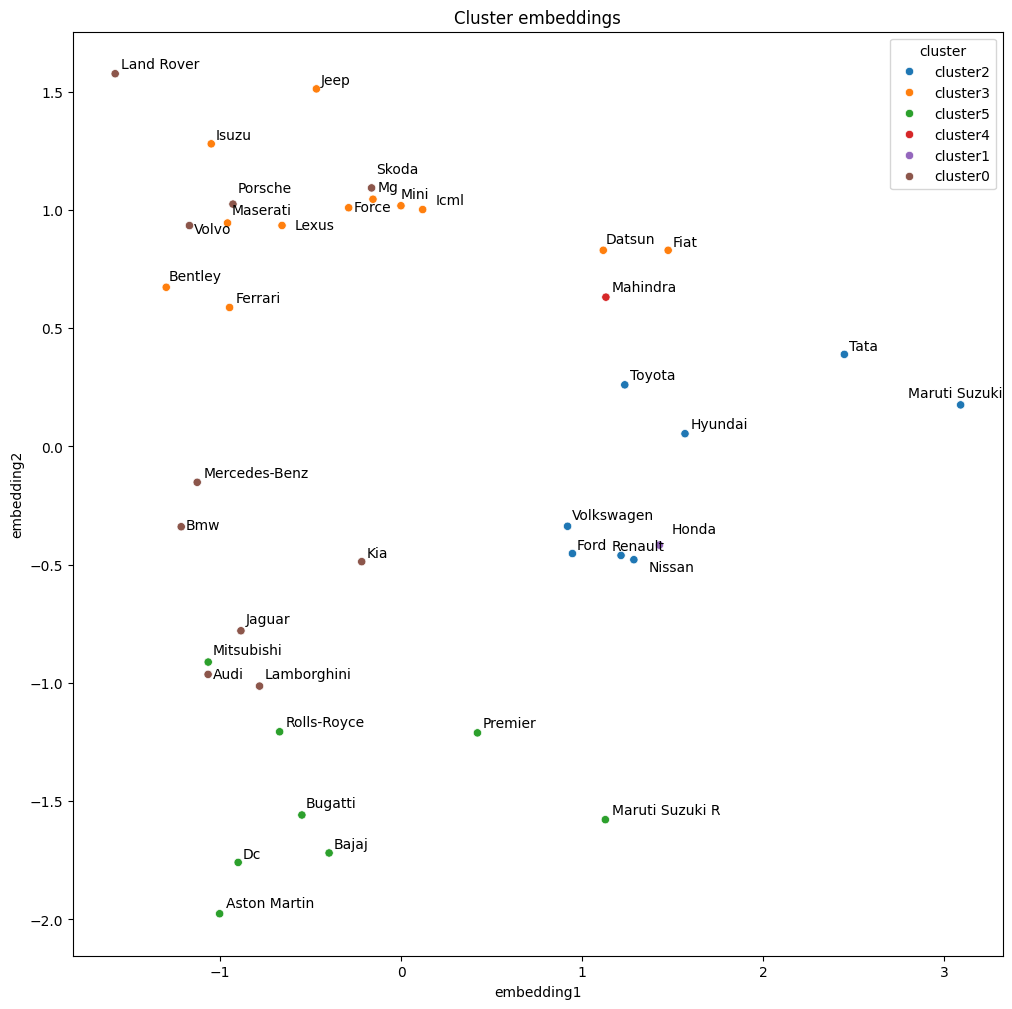

In [ ]:
plot_clusters("cluster")

In [ ]:
from sklearn import metrics
metrics.adjusted_rand_score(plot_df.country, plot_df.cluster)

0.047037263286499695

In [ ]:
df.Price_Category.unique()
df

,Company,Model,Variant,Type,Seating_Capacity,Price,Fuel_Type,Wheelbase,Length,Width,...,Airbags,Front_Brakes,Front_Suspension,Rear_Brakes,Rear_Suspension,Drivetrain,Gears,Price_Category,Offroad_Capability,Car_Dimensions
0,Tata,Nano Genx,Xt,Hatchback,4.0,357053,Petrol,2230.0,3164,1750.0,...,NaN,Drum,"Independent, Lower Wishbone, McPherson Strut w...",Drum,"Independent, Semi Trailing arm with coil sprin...",RWD,4.0,Budget,Low,Small
1,Tata,Nano Genx,Xe,Hatchback,4.0,288465,Petrol,2230.0,3164,1750.0,...,NaN,Drum,"Independent, Lower Wishbone, McPherson Strut w...",Drum,"Independent, Semi Trailing arm with coil sprin...",RWD,4.0,Budget,Low,Small
2,Tata,Nano Genx,Emax Xm,Hatchback,4.0,361926,CNG,2230.0,3164,1750.0,...,NaN,Drum,"Independent, Lower Wishbone, McPherson Strut w...",Drum,"Independent, Semi Trailing arm with coil sprin...",RWD,4.0,Budget,Low,Small
3,Tata,Nano Genx,Xta,Hatchback,4.0,408416,Petrol,2230.0,3164,1750.0,...,NaN,Drum,"Independent, Lower Wishbone, McPherson Strut w...",Drum,"Independent, Semi Trailing arm with coil sprin...",RWD,5.0,Budget,Low,Small
4,Tata,Nano Genx,Xm,Hatchback,4.0,332112,Petrol,2230.0,3164,1750.0,...,NaN,Drum,"Independent, Lower Wishbone, McPherson Strut w...",Drum,"Independent, Semi Trailing arm with coil sprin...",RWD,4.0,Budget,Low,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,Honda,City,Vx Mt Diesel,Sedan,5.0,1588440,Diesel,2600.0,4440,1695.0,...,True,Ventilated Disc,"McPherson Strut, Coil Spring",Drum,"Torsion Beam Axle, Coil Spring",FWD,6.0,Mid-Range,Low,Small
1263,Honda,City,Zx Mt Diesel,Sedan,5.0,1733620,Diesel,2600.0,4440,1695.0,...,True,Ventilated Disc,"McPherson Strut, Coil Spring",Drum,"Torsion Beam Axle, Coil Spring",FWD,6.0,Mid-Range,Low,Small
1264,Honda,City,Zx Cvt Petrol,Sedan,5.0,1745820,Petrol,2600.0,4440,1695.0,...,True,Ventilated Disc,"McPherson strut,coil spring",Drum,"Torsion Beam Axle, Coil Spring",FWD,5.0,Mid-Range,Low,Small
1265,Honda,City,V Cvt Petrol,Sedan,5.0,1465220,Petrol,2600.0,4440,1695.0,...,True,Ventilated Disc,"McPherson Strut, Coil Spring",Drum,"Torsion Beam Axle, Coil Spring",FWD,5.0,Budget,Low,Small


# Classification


## Original dataset

In [ ]:
from sklearn.preprocessing import LabelEncoder

copy_df = df[['Width', 'Company', 'Gears', 'Price_Category']].copy()


# Encode the target variable
le = LabelEncoder()
copy_df['Price_Category'] = le.fit_transform(copy_df['Price_Category'])

# Select features and target variable
X = copy_df.drop(columns=['Price_Category'])
y = copy_df['Price_Category']

# If there are any categorical features in X, encode them as well
X = pd.get_dummies(X)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
!pip install xgboost==2.1.3

In [ ]:
import xgboost as xgb
import sklearn
print("XGBoost version:", xgb.__version__)
print("Scikit-learn version:", sklearn.__version__)

clf_model = xgb.XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")
clf_model.fit(X_train, y_train, verbose=1)

XGBoost version: 2.1.3
Scikit-learn version: 1.5.2


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [ ]:
from sklearn import metrics
metrics.accuracy_score(y_test, clf_model.predict(X_test))

0.8779527559055118

## Graph embedings

In [ ]:
company_embeddings = dict(zip(df.Company, model.get_embeddings(df.Company)))

def get_embeddings(team):
    return company_embeddings.get(team, np.full(200, np.nan))

X = np.array([get_embeddings(company) for company in df.Company])

y = copy_df['Price_Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_model = xgb.XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")
clf_model.fit(X_train, y_train, verbose=1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [ ]:
metrics.accuracy_score(y_test, clf_model.predict(X_test))

0.7834645669291339

# Link prediction

In [ ]:
def train_test_split_no_unseen(data, test_size):
    train_data, test_data = train_test_split(data, test_size=test_size)
    return train_data, test_data

X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=10000)

df = pd.DataFrame(X_train, columns=['subject', 'predicate', 'object'])

In [ ]:
carSubject = "Car_532"
print(df[df.subject==carSubject])

       subject               predicate                   object
749    Car_532         hasTransmission           Transmission_2
7582   Car_532            hasDimension                    Small
7644   Car_532                 hasMake                 Mahindra
7810   Car_532              hasVariant                      Zlx
8722   Car_532                hasModel        Bolero Power Plus
8980   Car_532  hasSuspensionAndBrakes  Suspension_&_Brakes_127
10131  Car_532    hasOffroadCapability                      Low
10720  Car_532                    type                      Car
12159  Car_532      hasExShowroomPrice                1081405.0
16585  Car_532           hasAppearance           Appearance_243
17668  Car_532               hasEngine               Engine_155


In [ ]:
dfFiltered = np.array(df[(df.subject!=carSubject) | ((df.subject==carSubject) & ~df.predicate.isin(["hasMake","hasTransmission"]))])

In [ ]:
model.fit(dfFiltered)

Epoch 1/100
21/21 [==============================] - 3s 136ms/step - loss: 342.4368
Epoch 2/100
21/21 [==============================] - 2s 117ms/step - loss: 342.1628
Epoch 3/100
21/21 [==============================] - 2s 118ms/step - loss: 341.8867
Epoch 4/100
21/21 [==============================] - 5s 223ms/step - loss: 341.6092
Epoch 5/100
21/21 [==============================] - 6s 292ms/step - loss: 341.3349
Epoch 6/100
21/21 [==============================] - 4s 167ms/step - loss: 341.0633
Epoch 7/100
21/21 [==============================] - 3s 136ms/step - loss: 340.7919
Epoch 8/100
21/21 [==============================] - 5s 249ms/step - loss: 340.5202
Epoch 9/100
21/21 [==============================] - 3s 121ms/step - loss: 340.2456
Epoch 10/100
21/21 [==============================] - 2s 117ms/step - loss: 339.9689
Epoch 11/100
21/21 [==============================] - 3s 138ms/step - loss: 339.6941
Epoch 12/100
21/21 [==============================] - 6s 284ms/step - loss

In [ ]:
statements = np.array([
    [f'{carSubject}', 'hasMake', 'Mahindra'],
    [f'{carSubject}', 'hasMake', 'Range'],
    [f'{carSubject}', 'hasTransmission', 'Transmission_2'],
    [f'{carSubject}', 'hasTransmission', 'Transmission_7'],
])

In [ ]:
statements_filter = np.array(list({tuple(i) for i in np.vstack((dfFiltered, statements))}))
statements_filter

array([['Appearance_249', 'type', 'Appearance'],
       ['Car_993', 'hasMake', 'Mg'],
       ['Car_911', 'hasOffroadCapability', 'Low'],
       ...,
       ['Appearance_235', 'hasBootSpace', 'nan'],
       ['Car_12', 'type', 'Car'],
       ['Car_1139', 'hasModel', 'Gla-Class']], dtype='<U195')

In [ ]:
scores = model.predict(statements)
scores

array([21.945423 ,  1.3371291, 20.655586 , 10.37624  ], dtype=float32)

In [ ]:
from scipy.special import expit
probs = expit(scores)

pd.DataFrame(list(zip([' '.join(x) for x in statements],
                      ranks,
                      np.squeeze(scores),
                      np.squeeze(probs))),
             columns=['statement', 'rank', 'score', 'prob']).sort_values("prob")

,statement,rank,score,prob
1,Car_532 hasMake Range,"[388, 1]",1.337129,0.792017
3,Car_532 hasTransmission Transmission_7,"[7, 54]",10.376240,0.999969
0,Car_532 hasMake Mahindra,"[640, 2]",21.945423,1.000000
2,Car_532 hasTransmission Transmission_2,"[1, 7]",20.655586,1.000000
